In [1]:
import scvelo as scv
import scanpy as sc
import scFates as scf
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import palantir
from cuml import UMAP
%matplotlib inline
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo',figsize=(5,5),dpi_save=600)

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']

In [2]:
import pandas as pd
auc=pd.read_csv("scenic/output/auc_mtx_mm10.csv",index_col=0)

In [3]:
def reprocess(adata,root,leaves):
    
    path=scf.tools.getpath(adata,root_milestone=root,milestones=leaves)
    path=path[~path.index.duplicated(keep='first')]
    import numpy as np

    colkeep=list(map(lambda m: adata.uns["milestones_colors"][np.argwhere(adata.obs.milestones.cat.categories==m)[0][0]],
         path.milestones.unique()))
    
    adata=adata[path.index,]
    dm_res = palantir.utils.run_diffusion_maps(auc.loc[path.index,:],knn=100)
    ms_data = palantir.utils.determine_multiscale_space(dm_res)
    umap = UMAP(n_components = 2,n_neighbors=150,min_dist=.4,n_epochs=2000,random_state=1)
    emb = umap.fit_transform(ms_data.values)
    plt.figure(figsize=(10,10))
    plt.scatter(emb[:,0],emb[:,1],c=adata.obs.t[ms_data.index],s=10,cmap="viridis")
    plt.axis("off")
    plt.tight_layout()
    adata.obsm["X_umap2"] = adata.obsm["X_umap"]
    adata.obsm["X_umap"] = emb
    
    del adata.uns
    
    adata.obs["old_milestones"] = adata.obs["milestones"]
    adata.obs.old_milestones=adata.obs.old_milestones.cat.reorder_categories(path.milestones.unique())
    adata.uns["old_milestones_colors"] = colkeep
    
    return adata

In [4]:
adata=sc.read("adata_tree_fpm.h5ad")

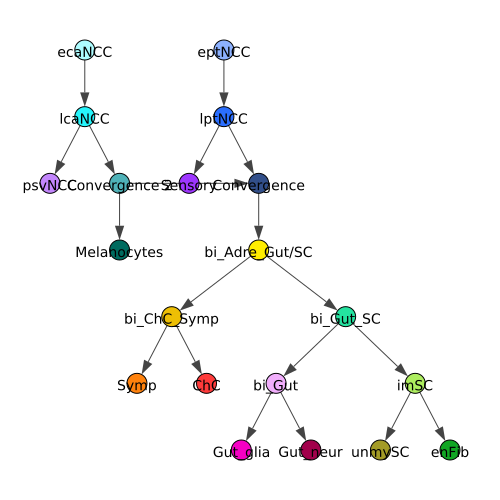

In [5]:
scf.pl.milestones(adata)

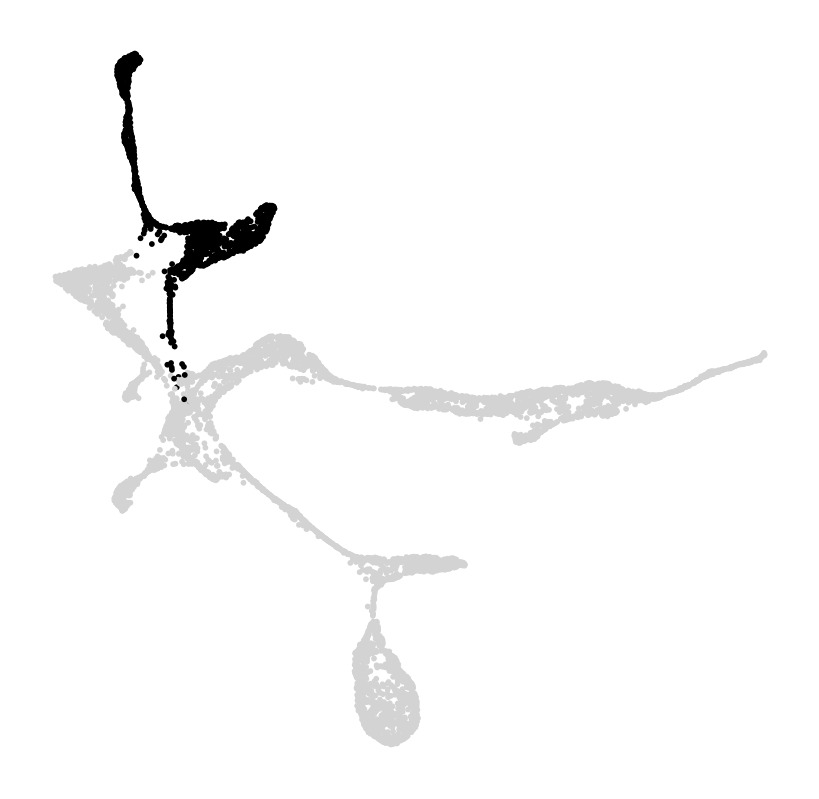

In [6]:
path=scf.tools.getpath(adata,"eptNCC",["Sensory","Convergence"])
path=path[~path.index.duplicated(keep='first')]
adata.obs["sel"]=adata.obs_names.isin(path.index)
adata.obs["sel"]=adata.obs["sel"].astype("category")
sc.pl.umap(adata,color="sel",palette=["lightgrey","black"],frameon=False,legend_loc="none",title="",
           save="-Bif_Sensory.png")

Determing nearest neighbor graph...


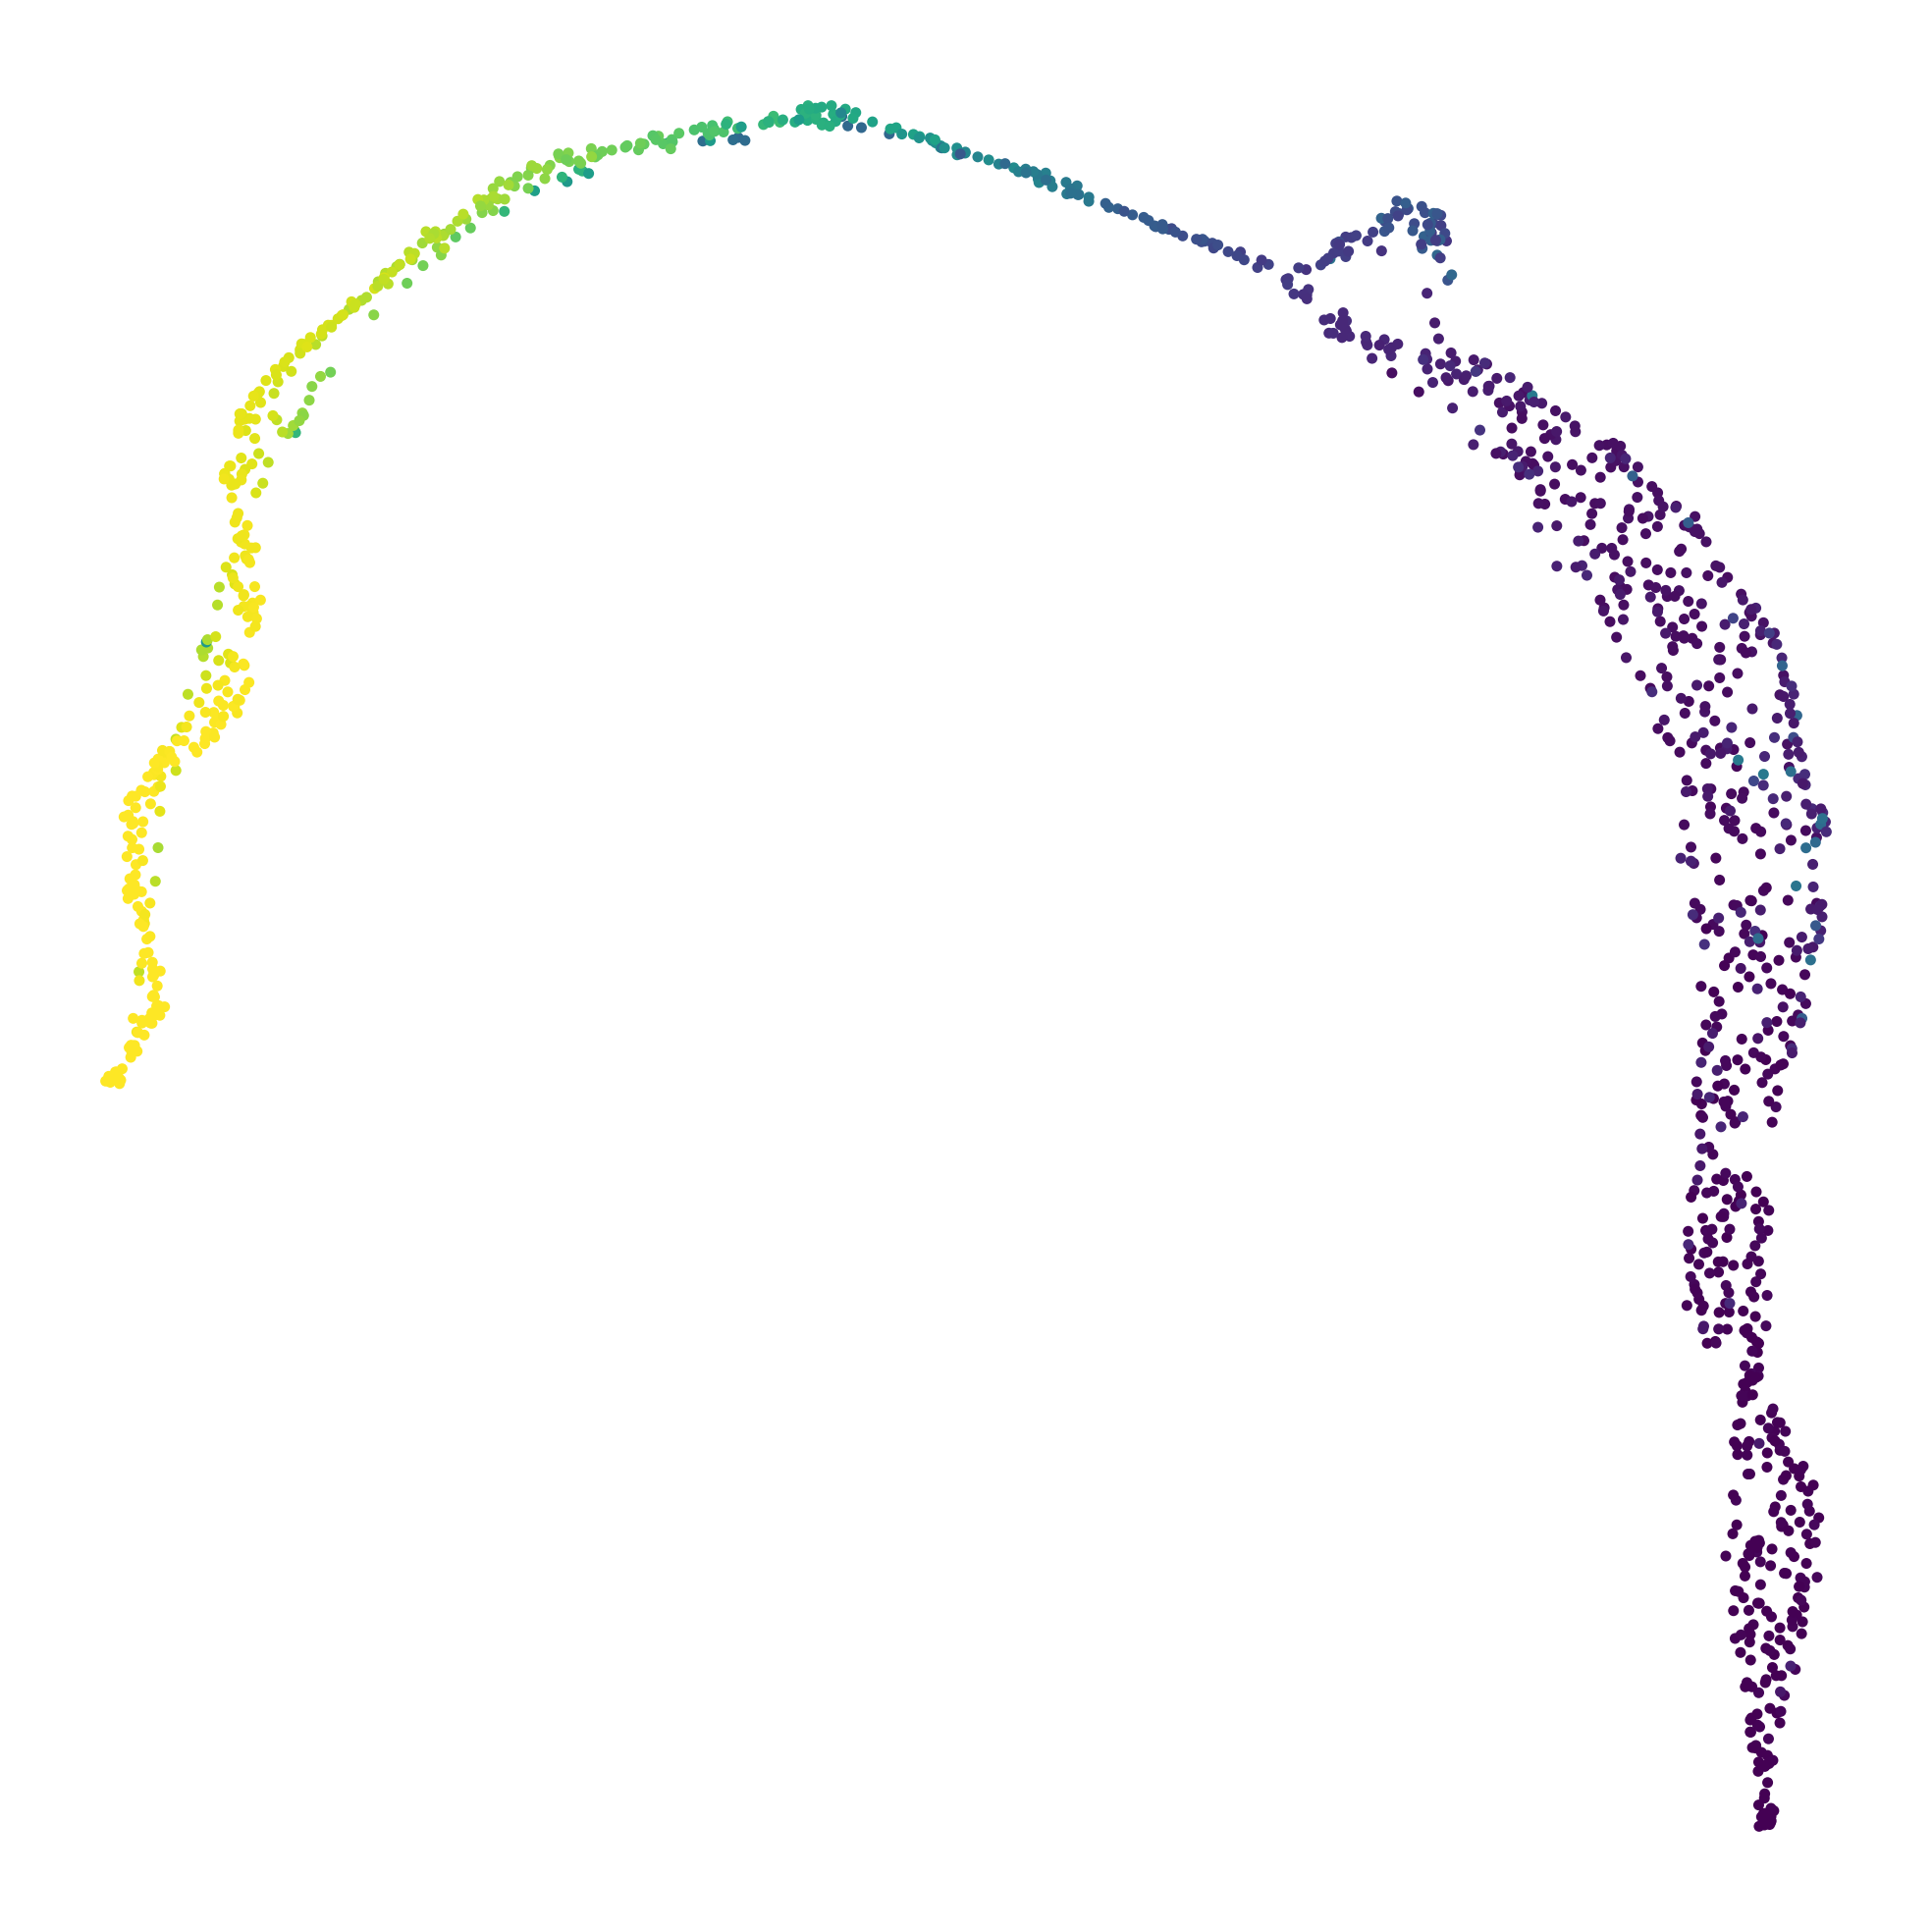

In [7]:
adata=reprocess(adata,"eptNCC",["Sensory","Convergence"])

In [8]:
scf.tl.tree(adata,Nodes=500,ppt_err_cut=0.01,
            use_rep="diffusion",ppt_sigma = 0.05,ppt_lambda=100,
            method="ppt",device="gpu",seed=1)

inferring a principal tree --> parameters used 
    500 principal points, sigma = 0.05, lambda = 100, metric = euclidean
    fitting:  26%|██▌       | 13/50 [00:02<00:07,  5.26it/s]
    converged
    finished (0:00:02) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['R'] soft assignment of cells to principal point in representation space.
    .uns['graph']['F'] coordinates of principal points in representation space.


    graph cleaned --> removed 85 principal points


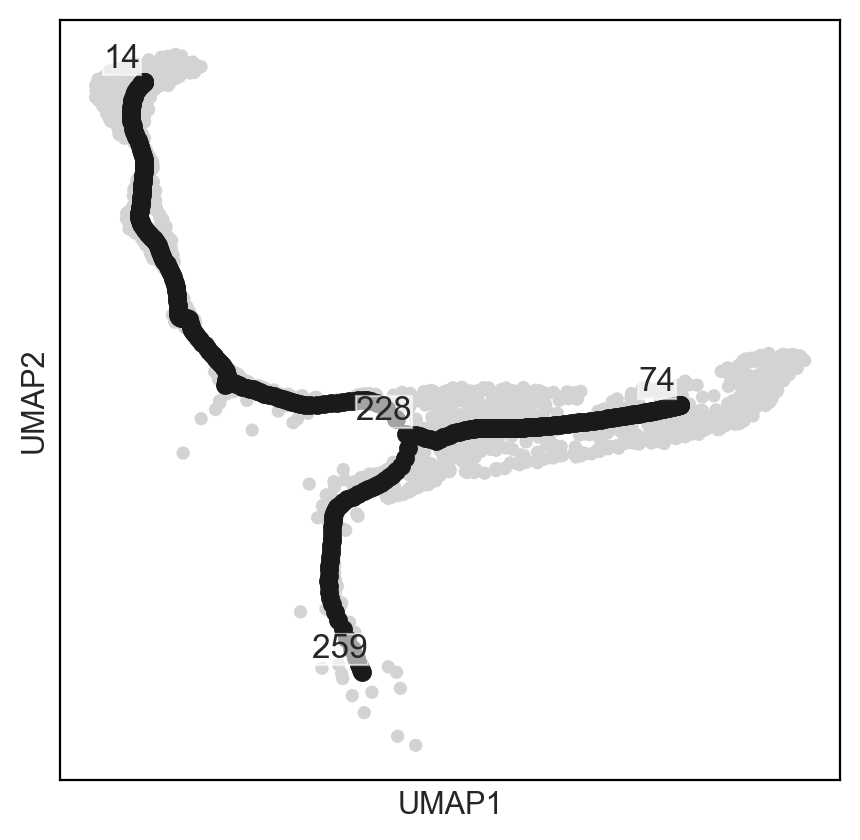

In [9]:
adata.obsm["X_umap"]=adata.obsm["X_umap2"]
scf.tl.cleanup(adata,minbranchlength=50)
scf.pl.graph(adata)

In [10]:
scf.tl.root(adata,74)

root selected --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


In [11]:
scf.tl.pseudotime(adata,n_jobs=40)

projecting cells onto the principal graph
    finished (0:00:01) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


In [12]:
adata.uns["graph"]["milestones"]

{'14': 14, '228': 228, '259': 259, '74': 74}

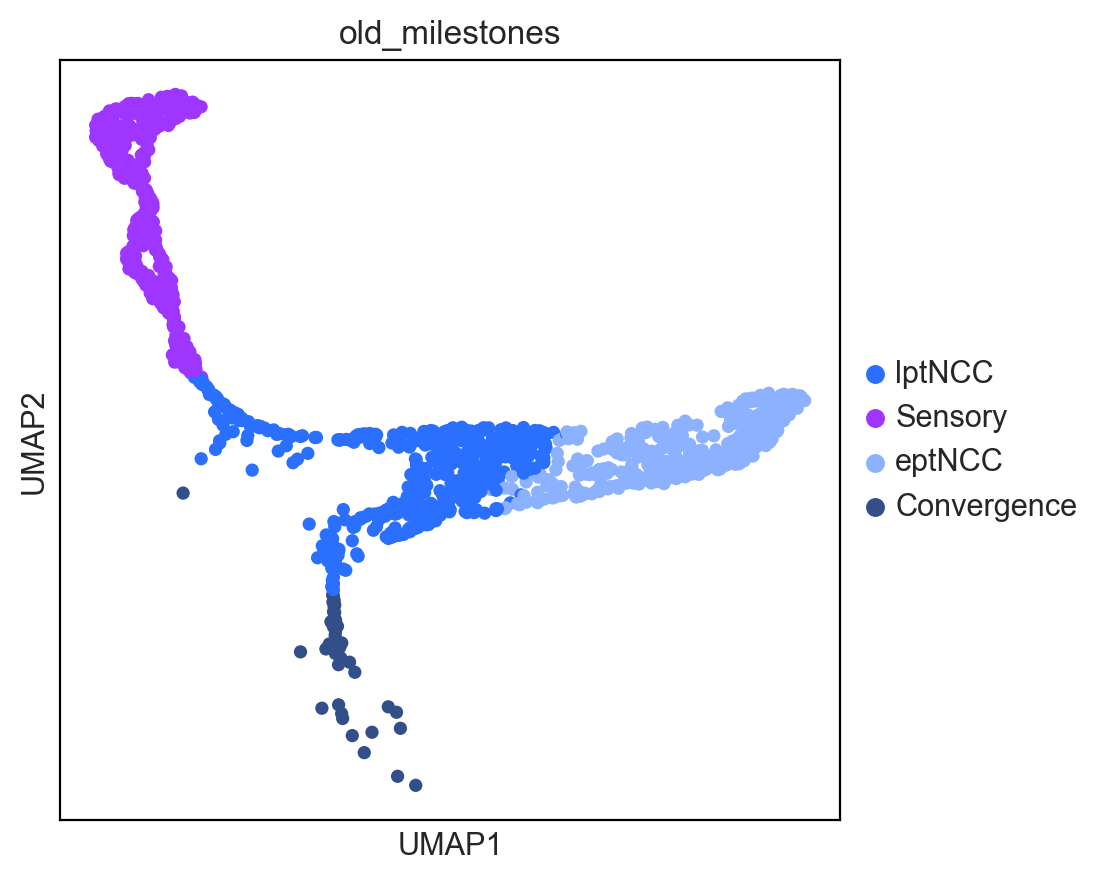

In [13]:
sc.pl.umap(adata,color="old_milestones")

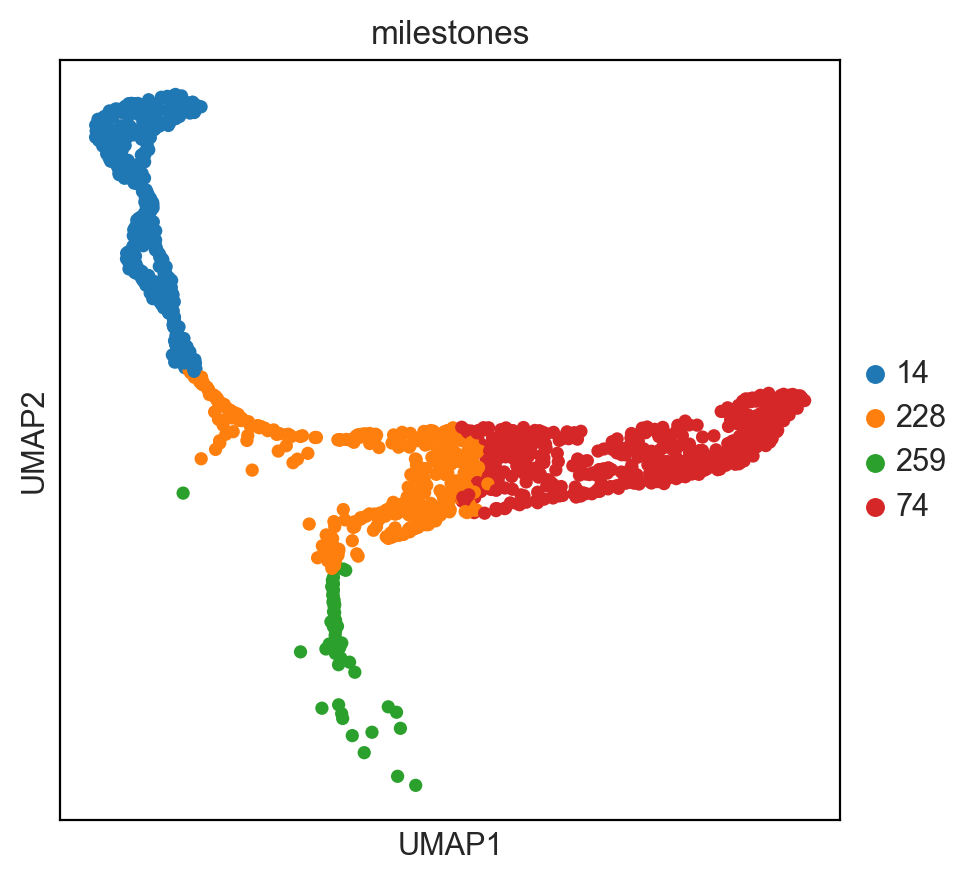

In [14]:
sc.pl.umap(adata,color="milestones")

In [15]:
mil=["Sensory","lptNCC","Convergence","eptNCC"]
scf.tl.rename_milestones(adata,mil)
adata.uns["graph"]["milestones"]

{'Sensory': 14, 'lptNCC': 228, 'Convergence': 259, 'eptNCC': 74}

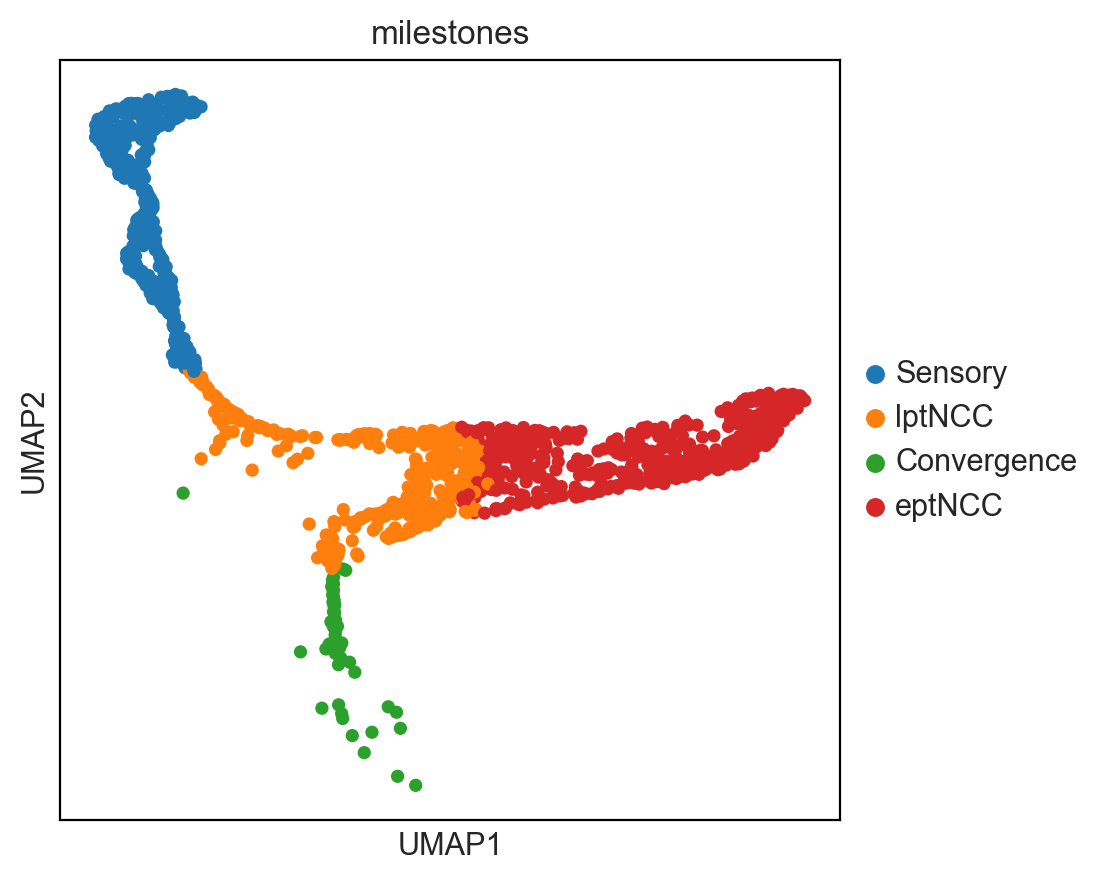

In [16]:
sc.pl.umap(adata,color="milestones")

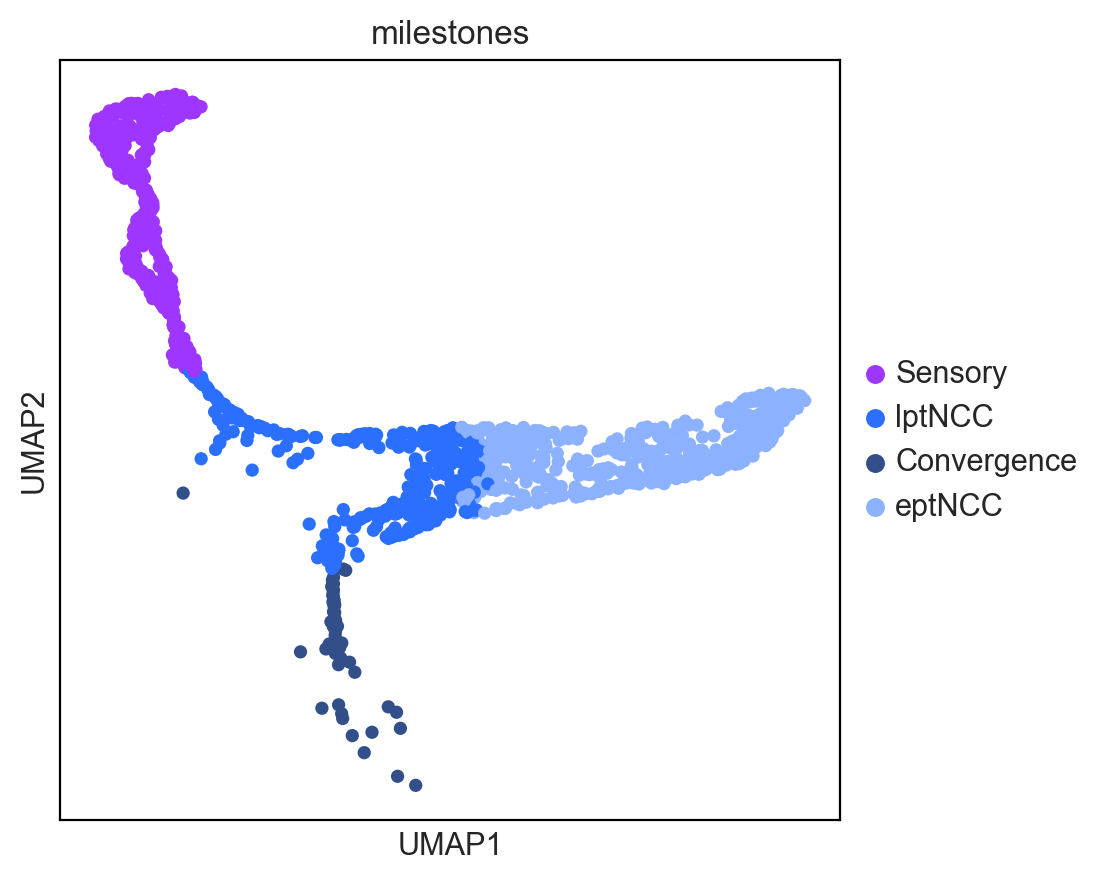

In [17]:
dct=dict(zip(adata.obs.old_milestones.cat.categories,adata.uns["old_milestones_colors"]))
adata.uns["milestones_colors"]=[dct[idx] for idx in adata.obs.milestones.cat.categories]
sc.pl.umap(adata,color="milestones")

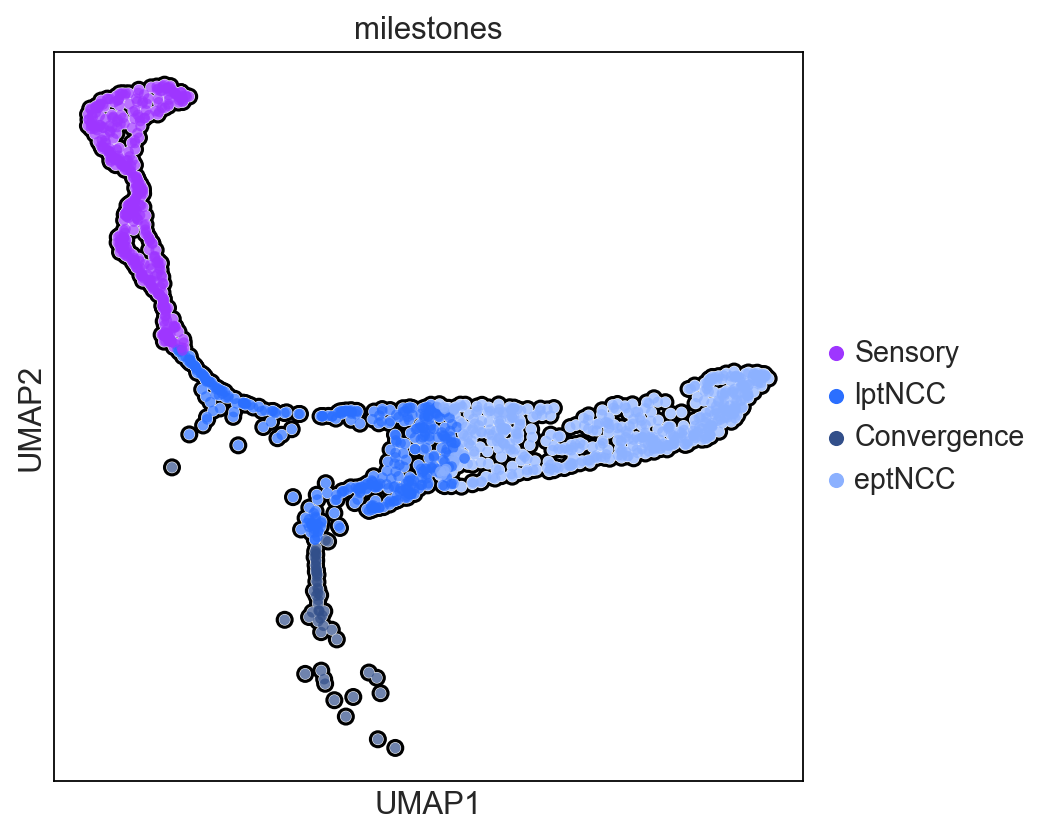

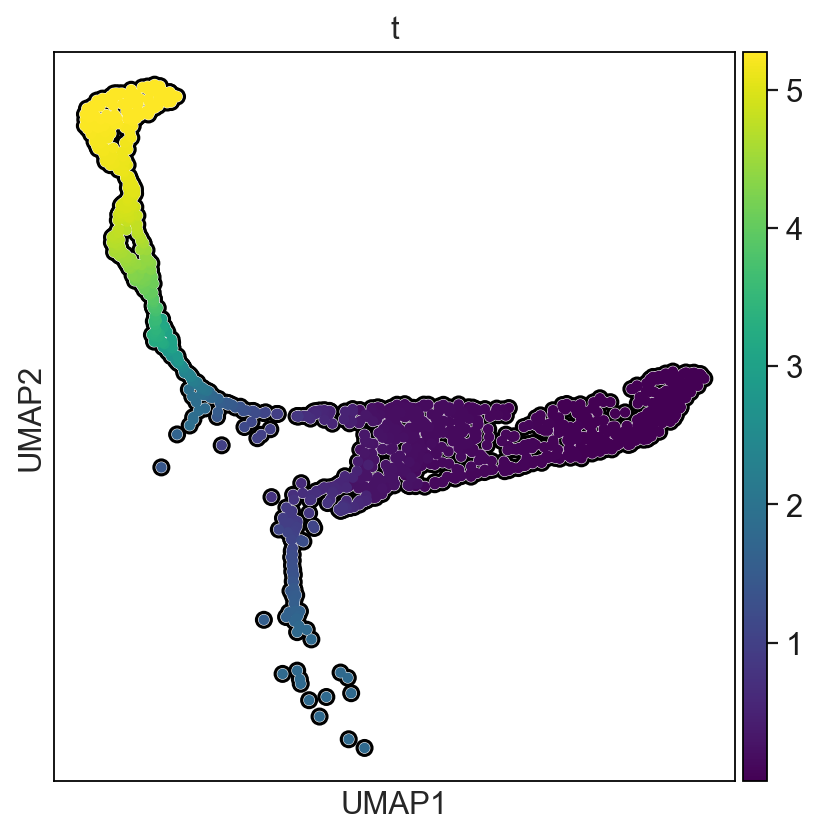

In [23]:
sc.set_figure_params(figsize=(6,6),dpi_save=600)
sc.pl.umap(adata,color="milestones",add_outline=True,save="milestones-Sensory.svg")
sc.pl.umap(adata,color="t",add_outline=True,color_map="viridis",alpha=1,save="pseudotime-Sensory.svg")

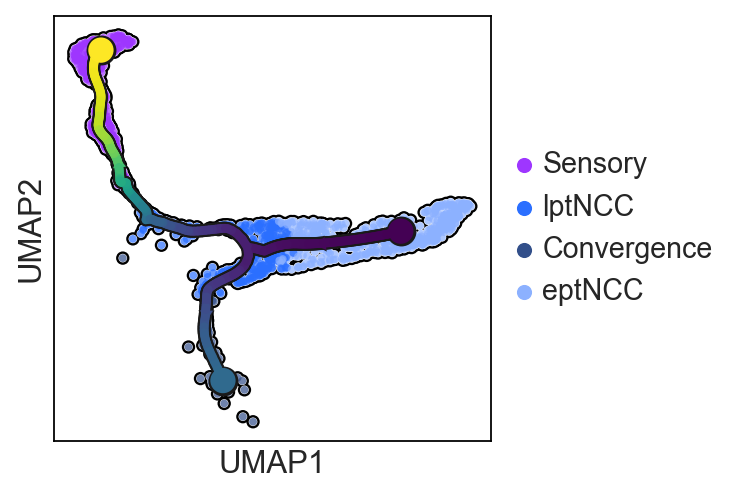

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3.5,3.5))
sc.pl.umap(adata,color="milestones",show=False,add_outline=True,ax=ax,size=50)
scf.pl.trajectory(adata,arrows=True,scale_path=.8,alpha=0,ax=ax,arrow_offset=10,
                  save="-Bif_Sensory.svg")

In [36]:
sc.pp.filter_genes(adata,min_cells=3)
scf.tl.test_association(adata,n_jobs=40,n_map=1)

test features for association with the trajectory
    single mapping : 100%|██████████| 18324/18324 [01:15<00:00, 243.18it/s]
    found 3116 significant features (0:01:16) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


In [37]:
root_mil="eptNCC"
miles=["Sensory","Convergence"]

In [38]:
scf.tl.test_fork(adata,root_milestone=root_mil,milestones=miles,n_jobs=20,rescale=True,n_map=1)

testing fork
    single mapping
    differential expression: 100%|██████████| 18324/18324 [01:13<00:00, 249.48it/s]
    test for upregulation for each leave vs root
    leave Convergence: 100%|██████████| 10743/10743 [00:03<00:00, 3560.04it/s]
    finished (0:01:23) --> added 
    .uns['eptNCC->Sensory<>Convergence']['fork'], DataFrame with fork test results.


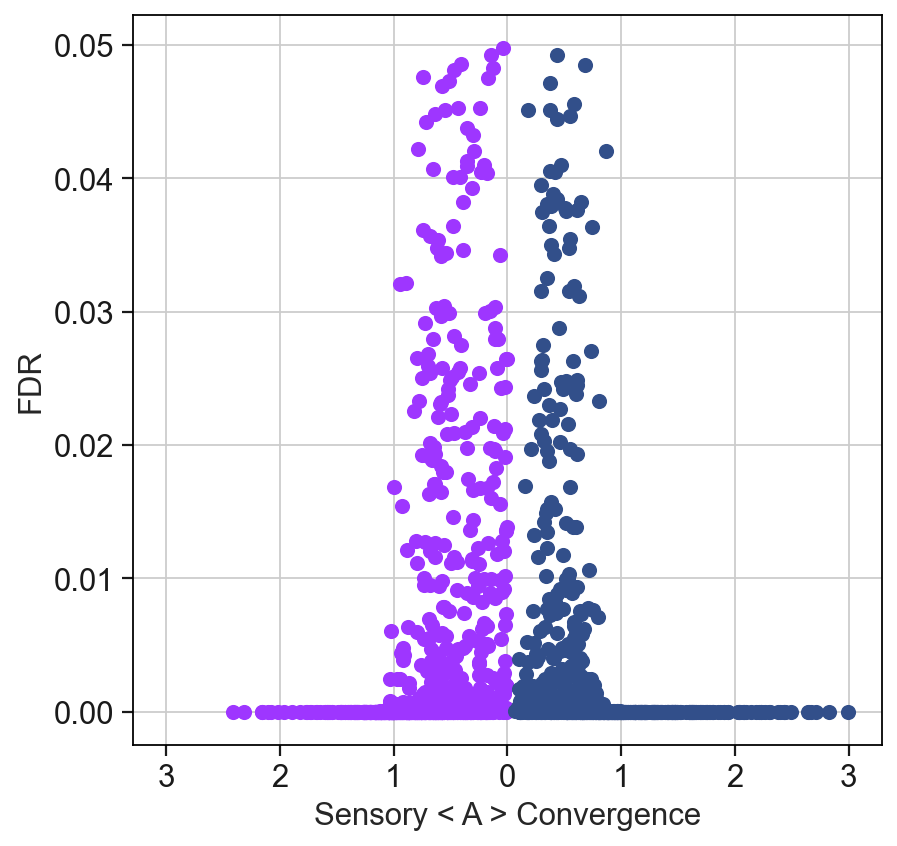

In [39]:
sc.set_figure_params(figsize=(6,6))
scf.pl.test_fork(adata,root_milestone=root_mil,milestones=miles)

In [40]:
scf.tl.branch_specific(adata,root_milestone=root_mil,milestones=miles,effect=1)

    branch specific features: Sensory: 195, Convergence: 49
    finished --> updated 
    .uns['eptNCC->Sensory<>Convergence']['fork'], DataFrame updated with additionnal 'branch' column.


In [41]:
scf.tl.activation(adata,root_milestone=root_mil,milestones=miles,n_jobs=20,
                  pseudotime_offset=0.1,deriv_cut=.2)

testing activation
    leave Convergence: 100%|██████████| 49/49 [00:00<00:00, 227.87it/s]
    threshold pseudotime is: 0.2930081416552227
    18 early and 177 late features specific to leave Sensory
    25 early and 24 late features specific to leave Convergence
    finished (0:00:03) --> updated 
    .uns['eptNCC->Sensory<>Convergence']['fork'], DataFrame updated with additionnal 'activation' and 'module' columns.


In [43]:
scf.tl.fit(adata,n_jobs=40,n_map=1)

fit features associated with the trajectory
    single mapping : 100%|██████████| 3116/3116 [00:35<00:00, 88.13it/s] 
    finished (adata subsetted to keep only fitted features!) (0:00:38) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


In [47]:
df=adata.uns['eptNCC->Sensory<>Convergence']['fork']

Index(['Thsd7b', 'St18', 'Slco5a1', 'Klf7', 'Nfasc', 'Tmcc2', 'Cntn2', 'Igsf9',
       'Cnst', 'Gdap1',
       ...
       'Fbxl16', 'Mtcl1', 'Myo5b', 'Zeb1', 'Epb4.1l4a', 'Synpo', 'Sptbn2',
       'Hspa12a', 'Ctsf', 'Flrt1'],
      dtype='object', length=195)

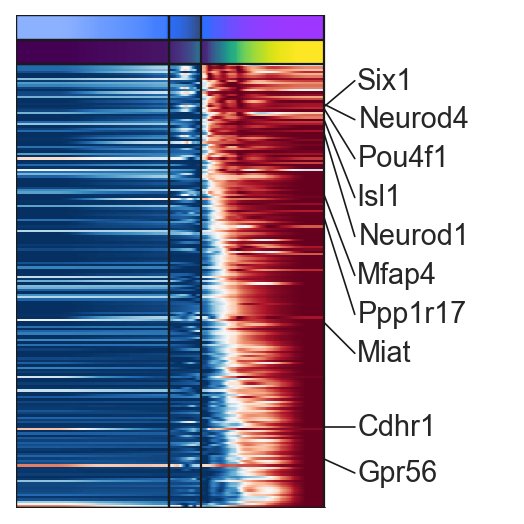

In [63]:
scf.pl.trends(adata,features=df.index[df.branch=="Sensory"],annot="milestones",
              plot_emb=False,fig_heigth=3.5,heatmap_space=.4,offset_names=.1,fontsize=13,save="Sensorybif_sensory.svg")

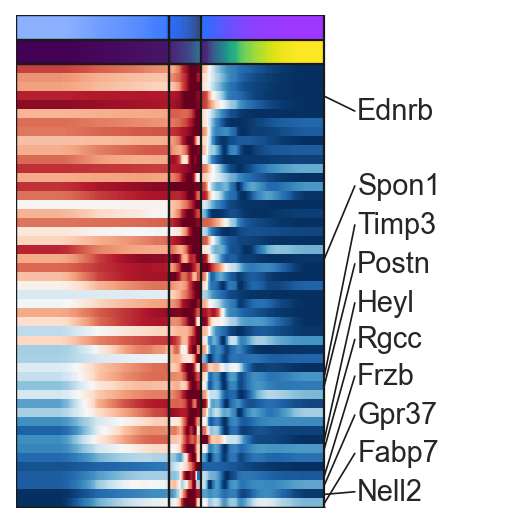

In [64]:
scf.pl.trends(adata,features=df.index[df.branch=="Convergence"],annot="milestones",
              plot_emb=False,fig_heigth=3.5,heatmap_space=.4,offset_names=.1,fontsize=13,save="Sensorybif_convergence.svg")

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/scFates/plot/trajectory.py:311: RuntimeWarning: Mean of empty slice.
  vals[adata[(sorted_edges == e).sum(axis=1) == 2].obs_names].values.mean()
/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


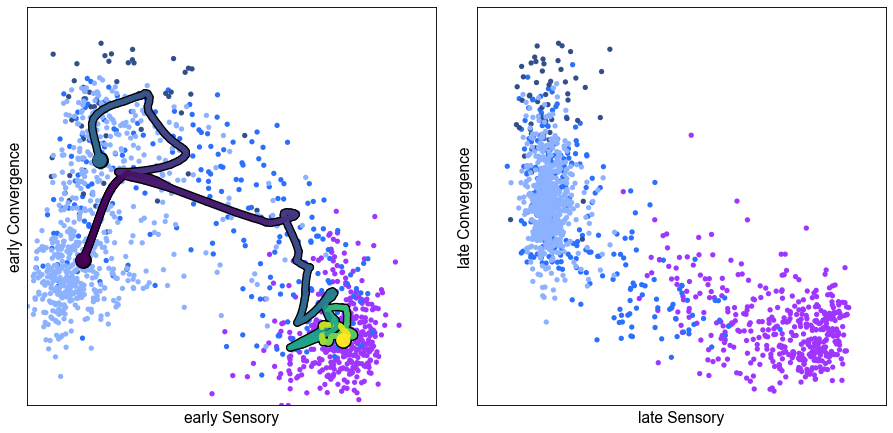

In [11]:
scf.pl.modules(adata,root_milestone=root_mil,milestones=miles,color="milestones",show_traj=True,
              save="-Bif_Sensory.png")

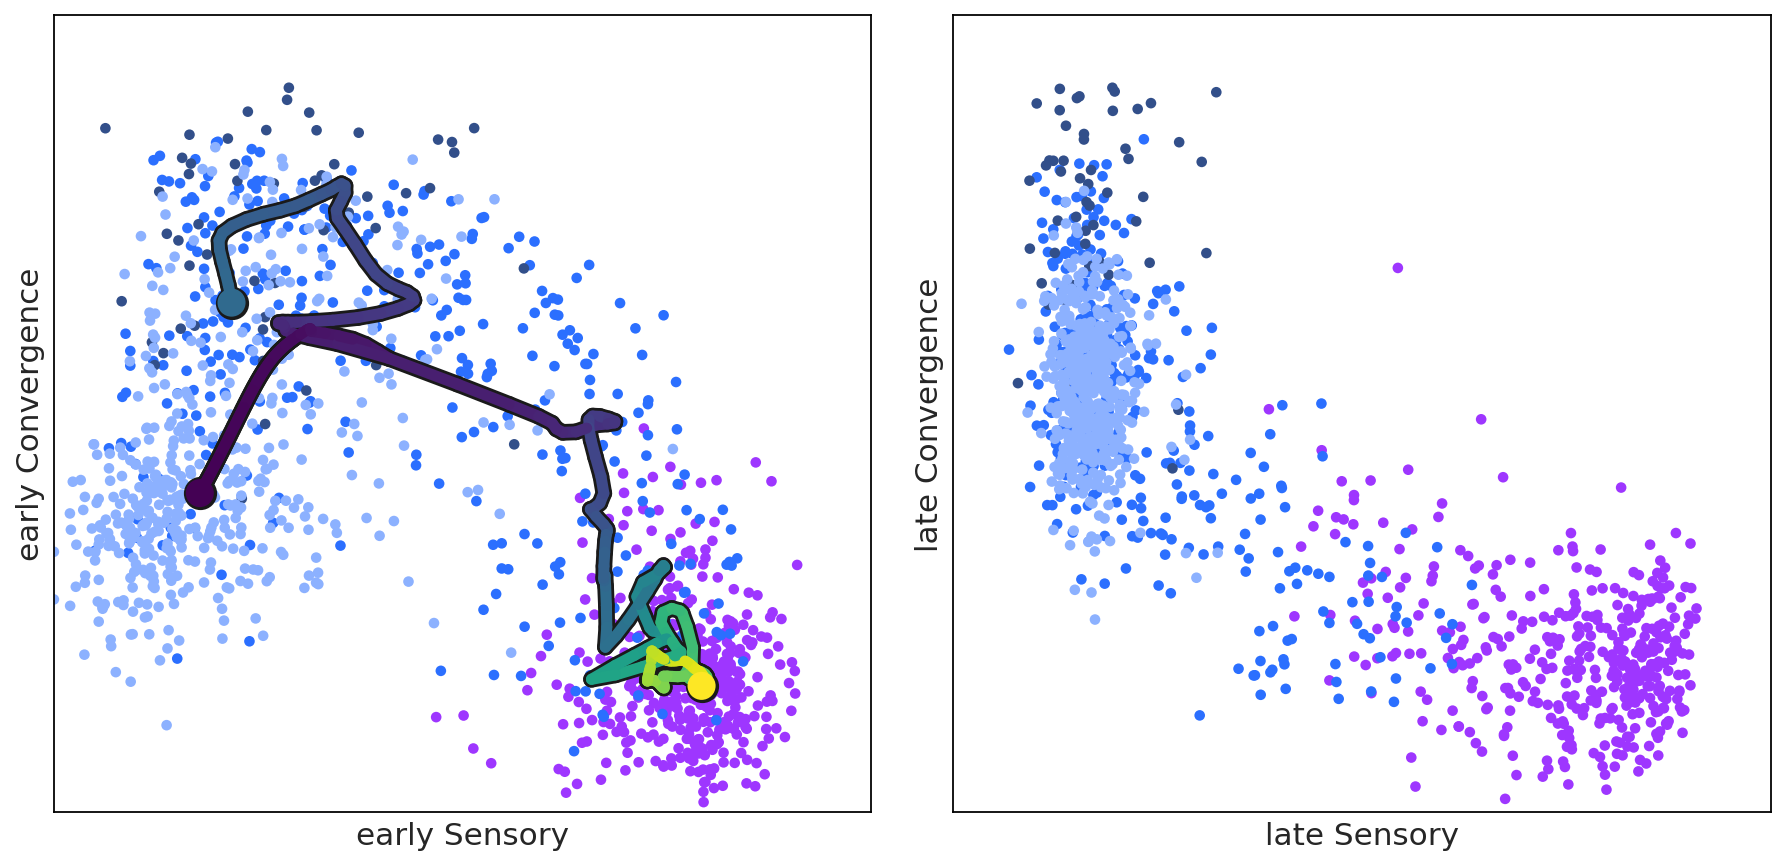

In [27]:
scf.pl.modules(adata,root_milestone=root_mil,milestones=miles,color="milestones",show_traj=True,
              save="-Bif_Sensory.png")

In [12]:
scf.tl.slide_cells(adata,root_milestone=root_mil,milestones=miles,win=100)

--> added 
    .uns['eptNCC->Sensory<>Convergence']['cell_freq'], probability assignment of cells on 14 non intersecting windows.


In [13]:
scf.tl.slide_cors(adata,root_milestone=root_mil,milestones=miles)

--> added 
    .uns['eptNCC->Sensory<>Convergence']['corAB'], gene-gene correlation modules.


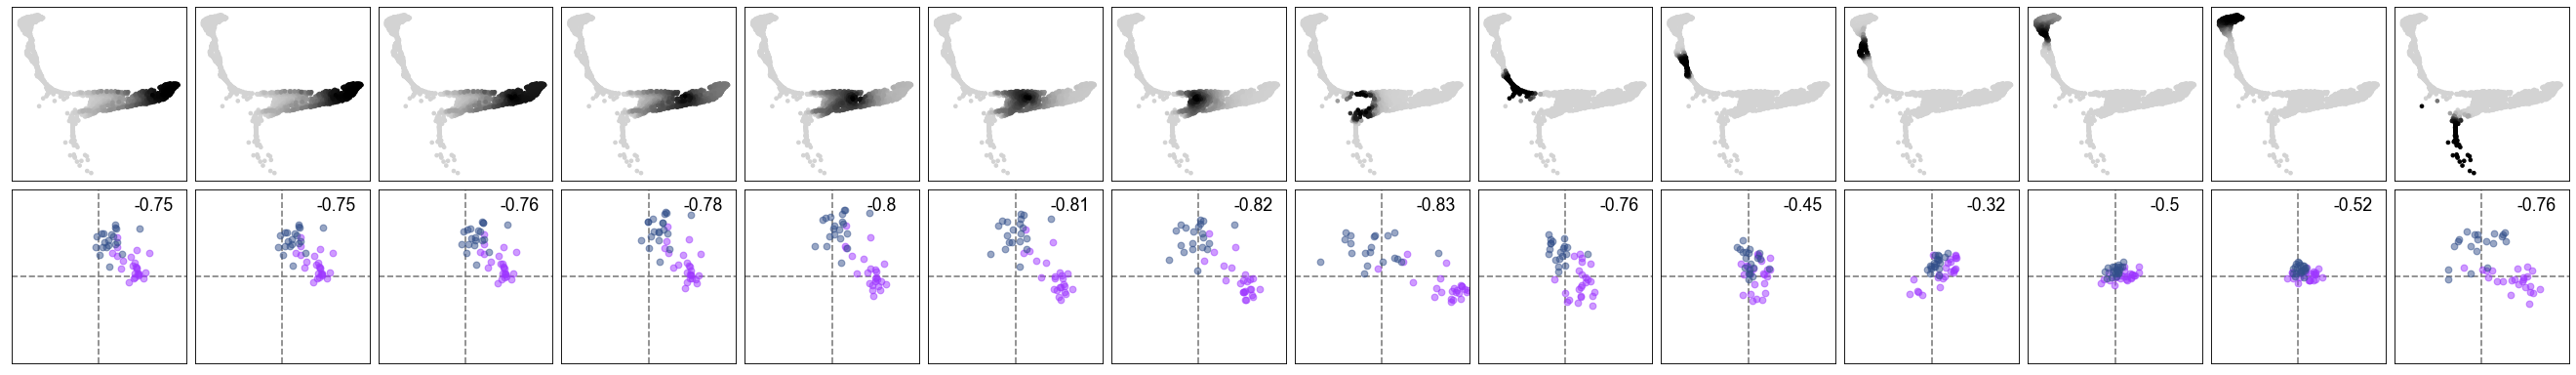

In [14]:
scf.pl.slide_cors(adata,root_milestone=root_mil,milestones=miles)

In [34]:
del adata.uns['eptNCC->Sensory<>Convergence']['corAB']

In [ ]:
del adata.obs["sel"]

In [36]:

adata.write_h5ad("adata_temp.h5ad")

In [28]:
import scanpy as sc
import scFates as scf
adata=sc.read("adata_temp.h5ad")
root_mil = "eptNCC"
miles = ["Sensory","Convergence"]

scf.tl.synchro_path(adata,root_milestone=root_mil,milestones=miles,w=250,step=15,winp=20,loess_span=.3)

 10%|▉         | 6/62 [00:00<00:01, 54.53it/s]

computing local correlations


100%|██████████| 37/37 [00:00<00:00, 81.67it/s]

    finished (0:00:03) --> added 
    .uns['eptNCC->Sensory<>Convergence']['syncho'], mean local gene-gene correlations of all possible gene pairs inside one module, or between the two modules.
    .obs['inter_cor eptNCC->Sensory<>Convergence'], loess fit of inter-module mean local gene-gene correlations prior to bifurcation.



/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


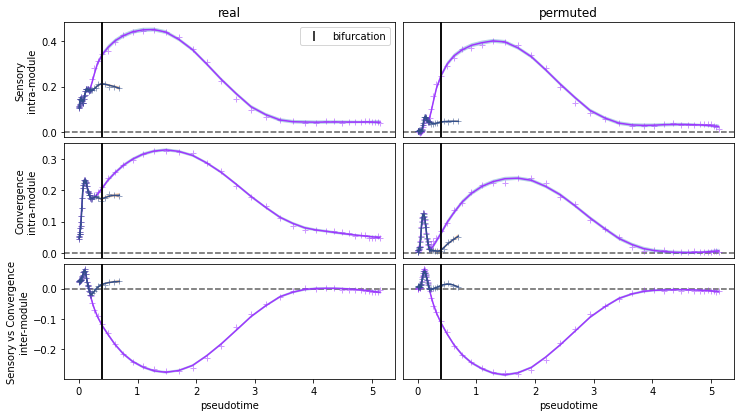

In [29]:
scf.pl.synchro_path(adata,root_milestone=root_mil,milestones=miles,loess_span=.3)

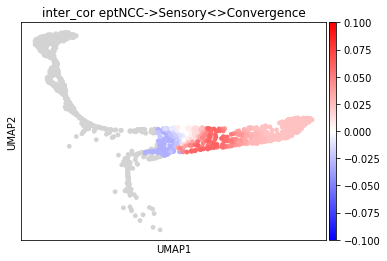

In [25]:
sc.pl.umap(adata,color='inter_cor eptNCC->Sensory<>Convergence',cmap="bwr",vmin = -0.1,vmax=.1)

In [13]:
df.loc[df.branch=="Convergence"].sort_values("Sensory").to_csv("Sensory.csv")

In [16]:
adata.write_h5ad("adata_temp.h5ad")

In [1]:
import scanpy as sc
import scFates as scf
adata=sc.read("adata_temp.h5ad")
root_mil = "eptNCC"
miles = ["Sensory","Convergence"]
df = adata.uns['eptNCC->Sensory<>Convergence']['fork']
sc.set_figure_params(dpi=300)
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']

scf.pl.trends(adata,features=df.index[(df.branch==miles[1])],
                    filter_complex=False,ordering="pearson",save="-_"+miles[1]+"2.svg")
scf.pl.trends(adata,features=df.index[(df.branch==miles[1])],plot_emb=False,
                    filter_complex=False,ordering="pearson",save="-_"+miles[1]+"3.svg")

From cffi callback <function _processevents at 0x7effcdffb700>:
Traceback (most recent call last):
  File "/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/rpy2/rinterface_lib/callbacks.py", line 277, in _processevents
    try:
  File "/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/rpy2/rinterface.py", line 84, in _sigint_handler
    raise KeyboardInterrupt()
KeyboardInterrupt
From cffi callback <function _processevents at 0x7effcdffb700>:
Traceback (most recent call last):
  File "/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/rpy2/rinterface_lib/callbacks.py", line 277, in _processevents
    try:
  File "/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/rpy2/rinterface.py", line 84, in _sigint_handler
    raise KeyboardInterrupt()
KeyboardInterrupt
From cffi callback <function _processevents at 0x7effcdffb700>:
Traceback (most recent call last):
  File "/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8

Traceback (most recent call last):
  File "/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-b2f00b7fa370>", line 2, in <module>
    import scFates as scf
  File "/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/scFates/__init__.py", line 4, in <module>
    from . import tl
  File "/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/scFates/tl.py", line 1, in <module>
    from scFates.tools import *
  File "/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/scFates/tools/__init__.py", line 3, in <module>
    from .test_association import test_association
  File "/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/scFates/tools/test_association.py", line 63, in <module>
    rmgcv = importr("mgcv")
  File "/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-pack

TypeError: object of type 'NoneType' has no len()

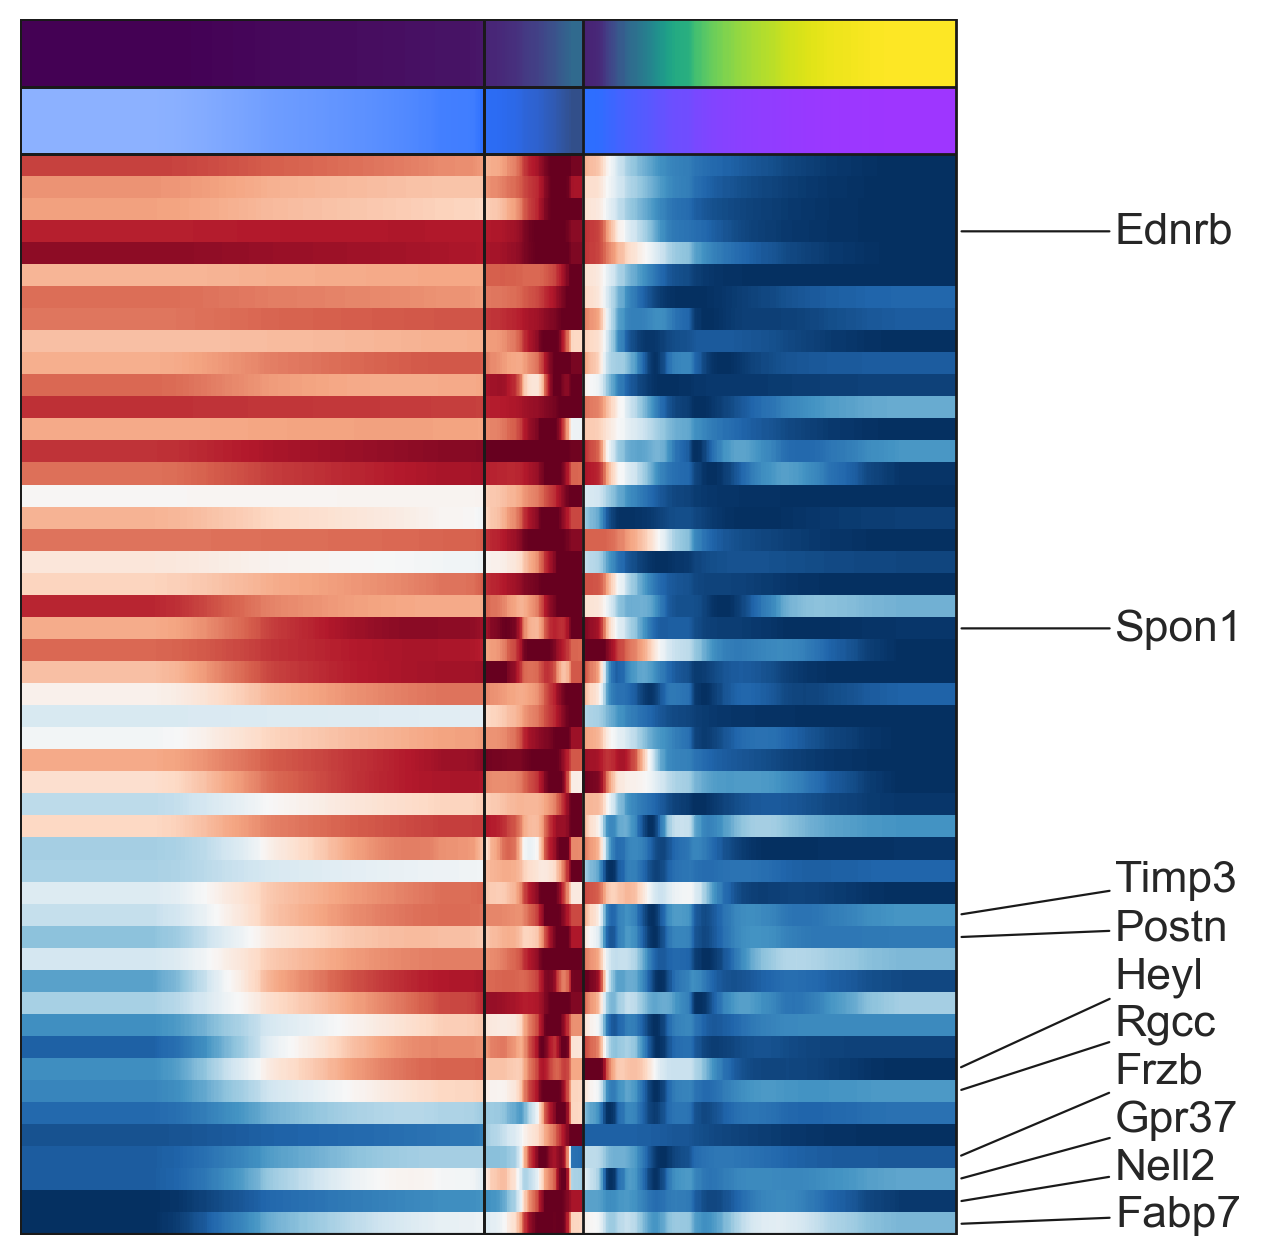

In [19]:
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']

scf.pl.trends(adata,features=df.index[(df.branch==miles[1])],
                    filter_complex=False,ordering="pearson",fontsize=16,
                    save="-_"+miles[1]+".svg")

In [20]:
df.loc[df.branch=="Convergence"].sort_values("Sensory").to_csv("Sensory.csv")

In [207]:
import numpy as np
import pandas as pd
from anndata import AnnData

import igraph
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
from matplotlib.gridspec import GridSpec
from scipy import stats
from adjustText import adjust_text
from matplotlib import patches
from scipy import sparse
import scanpy as sc

import warnings
from typing import Union, Optional
from scanpy.plotting._utils import savefig_or_show

features = df.index[(df.branch==miles[1])]
highlight_features = None
n_features: int = 10
root_milestone = None
milestones = None
show_milestones: bool = True
plot_emb: bool = True
cell_size = 20
cells = None
highlight = True
fontsize = 11
order = True
ordering = "pearson"
ord_thre = .7
filter_complex=False
complex_thre = .7
complex_z = 3
fig_heigth = 4
frame: Union[float,None] = 2
basis: str = "umap"
colormap: str = "RdBu_r"
pseudo_colormap: str = "viridis"
emb_back = None
show: Optional[bool] = None
save: Union[str, bool, None] = None
save_genes: Optional[bool] = None


graph = adata.uns["graph"]

if root_milestone is not None:
    adata = adata.copy()
    dct = graph["milestones"]
    keys = np.array(list(dct.keys()))
    vals = np.array(list(dct.values()))

    leaves = list(map(lambda leave: dct[leave],milestones))
    root = dct[root_milestone]
    df = adata.obs.copy(deep=True)
    edges=adata.uns["graph"]["pp_seg"][["from","to"]].astype(str).apply(tuple,axis=1).values
    img = igraph.Graph()
    img.add_vertices(np.unique(adata.uns["graph"]["pp_seg"][["from","to"]].values.flatten().astype(str)))
    img.add_edges(edges)
    cells=np.unique(np.concatenate(list(map(lambda leave: 
                                            getpath(img,root,
                                                    adata.uns["graph"]["tips"],
                                                    leave,adata.uns["graph"],df).index,
                                            leaves))))

    adata=adata[cells]



if features is None:
    features = adata.var_names

fitted = pd.DataFrame(adata.layers["fitted"],index=adata.obs_names,columns=adata.var_names).T.copy(deep=True)
g = adata.obs.groupby('seg')
seg_order=g.apply(lambda x: np.mean(x.t)).sort_values().index.tolist()
cell_order=np.concatenate(list(map(lambda x: adata.obs.t[adata.obs.seg==x].sort_values().index,seg_order)))
fitted=fitted.loc[:,cell_order]
#fitted=fitted.apply(lambda x: (x-x.mean())/x.std(),axis=1)

fitted=fitted.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis=1)

if filter_complex:
    # remove complex features using quantiles
    varia = list(map(lambda x: adata.obs.t[cell_order][fitted.loc[x,:].values>np.quantile(fitted.loc[x,:].values,q=complex_thre)].var(),features))
    z = np.abs(stats.zscore(varia))
    torem = np.argwhere(z > complex_z).flatten()

    if len(torem)>0:
        logg.info("found "+str(len(torem))+" complex fitted features")
        logg.hint( "added\n" + "    'complex' column in (adata.var)")
        adata.var["complex"]=False
        #adata.var.iloc[torem,"complex"]=True
        adata.var.loc[fitted.index[torem],"complex"]=True
        features=adata.var_names[~adata.var["complex"]]

fitted = fitted.loc[features,:]

In [208]:
if order:
    if ordering=="quantile":
        feature_order = fitted.apply(lambda x: adata.obs.t[fitted.columns][x>np.quantile(x,q=ord_thre)].mean(),axis=1).sort_values().index
    elif ordering=="max":
        feature_order = fitted.apply(lambda x: adata.obs.t[fitted.columns][(x-x.min())/(x.max()-x.min())>ord_thre].mean(),axis=1).sort_values().index
    elif ordering in ("pearson", "spearman"):
        start_feature = fitted.apply(lambda x: adata.obs.t[fitted.columns][(x-x.min())/(x.max()-x.min())>ord_thre].mean(),axis=1).sort_values().index[0]
        feature_order = fitted.T.corr(method=ordering).loc[start_feature,:].sort_values(ascending=False).index

    fitted_sorted = fitted.loc[feature_order, :]
else:
    fitted_sorted = fitted

In [209]:
color_key = "milestones_colors"
if color_key not in adata.uns or len(adata.uns[color_key])==1:
    from . import palette_tools
    palette_tools._set_default_colors_for_categorical_obs(adata,"milestones")

def milestones_prog(s):
    cfrom=adata.obs.t[adata.obs.seg==s].idxmin()
    cto=adata.obs.t[adata.obs.seg==s].idxmax()
    mfrom=adata.obs.milestones[cfrom]
    mto=adata.obs.milestones[cto]
    import numpy as np
    mfrom_c=adata.uns["milestones_colors"][np.argwhere(adata.obs.milestones.cat.categories==mfrom)[0][0]]
    mto_c=adata.uns["milestones_colors"][np.argwhere(adata.obs.milestones.cat.categories==mto)[0][0]]

    from matplotlib.colors import LinearSegmentedColormap

    cm=LinearSegmentedColormap.from_list("test",[mfrom_c,mto_c],N=1000)
    pst=(adata.obs.t[adata.obs.seg==s]-adata.obs.t[adata.obs.seg==s].min())/(adata.obs.t[adata.obs.seg==s].max()-adata.obs.t[adata.obs.seg==s].min())
    return pd.Series(list(map(to_hex,cm(pst))),index=pst.index)

mil_cmap=pd.concat(list(map(milestones_prog,seg_order)))

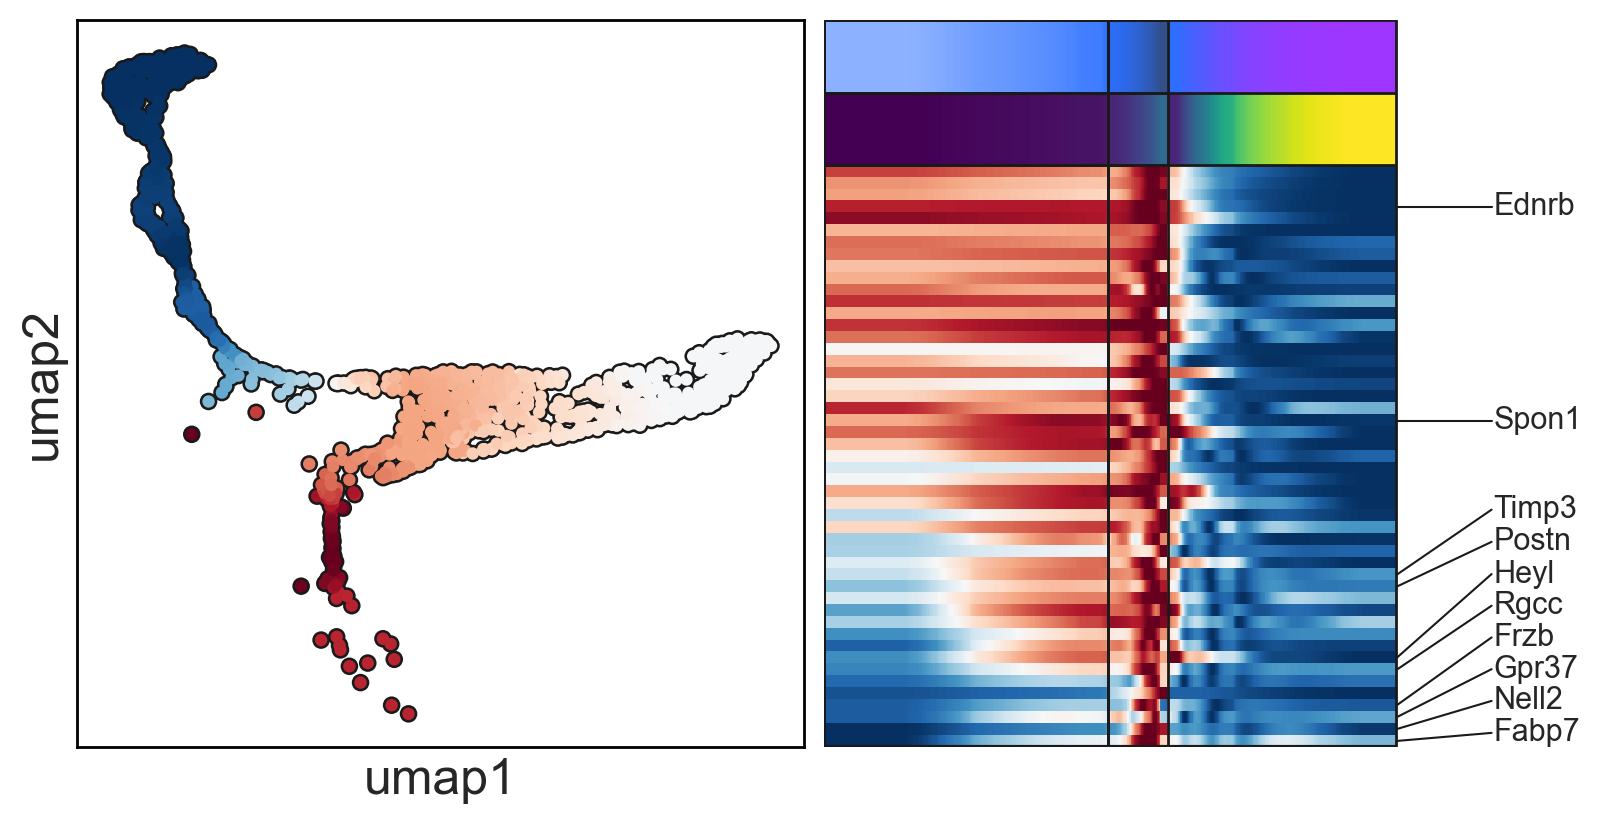

In [210]:
fig, f_axs = plt.subplots(ncols=2, nrows=10,figsize=(fig_heigth*(1+1*plot_emb),fig_heigth),
                         gridspec_kw={'width_ratios':[1*plot_emb,1]})
gs = f_axs[2, 1].get_gridspec()

# remove the underlying axes
start = 2 if show_milestones else 1
for ax in f_axs[start:, -1]:
    ax.remove()
axheatmap = fig.add_subplot(gs[start:, -1])


gs = f_axs[0, 0].get_gridspec()
# remove the underlying axes
for ax in f_axs[:, 0]:
    ax.remove()

if show_milestones:
    axmil = f_axs[0,1]
    sns.heatmap(pd.DataFrame(range(fitted_sorted.shape[1])).T,robust=False,rasterized=True,
                 cmap=mil_cmap[fitted_sorted.columns].values.tolist(),
                 xticklabels=False,yticklabels=False,cbar=False,ax=axmil)
    axpsdt = f_axs[1,1]

else:
    axpsdt = f_axs[0,1]


sns.heatmap(pd.DataFrame(adata.obs.t[fitted_sorted.columns].values).T,robust=True,rasterized=True,
                cmap=pseudo_colormap,xticklabels=False,yticklabels=False,cbar=False,ax=axpsdt,vmax=adata.obs.t.max())

sns.heatmap(fitted_sorted,robust=True,cmap=colormap,rasterized=True,
                xticklabels=False,yticklabels=False,ax=axheatmap,cbar=False)

def add_frames(axis,vert):
        rect = patches.Rectangle((0,0),len(fitted_sorted.columns),vert,linewidth=1,edgecolor='k',facecolor='none')
        # Add the patch to the Axes
        axis.add_patch(rect)
        offset=0
        for s in seg_order[:-1]:
            prev_offset=offset
            offset=offset+(adata.obs.seg==s).sum()
            rect = patches.Rectangle((prev_offset,0),(adata.obs.seg==s).sum(),vert,linewidth=1,edgecolor='k',facecolor='none')
            axis.add_patch(rect)
        return axis

axpsdt = add_frames(axpsdt,1)

if show_milestones:
    axmil = add_frames(axmil,1)
    
axheatmap=add_frames(axheatmap,fitted_sorted.shape[0])


if highlight_features is None:
    highlight_features = adata.var.A[features].sort_values(ascending=False)[:n_features].index
xs=np.repeat(fitted_sorted.shape[1],len(highlight_features))  
ys=np.array(list(map(lambda g: np.argwhere(fitted_sorted.index==g)[0][0],highlight_features)))+0.5

texts = []
for x, y, s in zip(xs, ys, highlight_features):
    texts.append(axheatmap.text(x, y, s, fontsize=fontsize))

patch = patches.Rectangle((0, 0), fitted_sorted.shape[1]+fitted_sorted.shape[1]/6, fitted_sorted.shape[0], alpha=0) # We add a rectangle to make sure the labels don't move to the right    
axpsdt.set_xlim((0,fitted_sorted.shape[1]+fitted_sorted.shape[1]/3))
if show_milestones:
    axmil.set_xlim((0,fitted_sorted.shape[1]+fitted_sorted.shape[1]/3))
axheatmap.set_xlim((0,fitted_sorted.shape[1]+fitted_sorted.shape[1]/3))
axheatmap.add_patch(patch)
axheatmap.hlines(fitted_sorted.shape[0],0,fitted_sorted.shape[1], color="k", clip_on=True) 


plt.tight_layout(h_pad=0,w_pad=0.05)

#adjust_text(texts,ax=axheatmap,add_objects=[patch],arrowprops=dict(arrowstyle='-', color='k'),va="center",ha="left",autoalign=False,
#    expand_text =(1.05,1.15), lim=5000,only_move={"points":"x", "text":"y", "objects":"x"},
#        precision=0.001, expand_points=(1.01, 1.05))

adjust_text(texts,ax=axheatmap,add_objects=[patch],va="center",ha="left",autoalign=False,
    expand_text =(1.05,1.15), lim=5000,only_move={"points":"x", "text":"y", "objects":"x"},
        precision=0.001, expand_points=(1.01, 1.05))

for i in range(len(xs)):
    xx=[xs[i]+1,fitted_sorted.shape[1]+fitted_sorted.shape[1]/6]
    yy=[ys[i],texts[i].get_position()[1]]
    axheatmap.plot(xx, yy,color="k",linewidth=0.75)


if plot_emb:
    axemb = fig.add_subplot(gs[:, 0])
    if emb_back is not None:
        axemb.scatter(emb_back[:,0],emb_back[:,1],s=cell_size,color="lightgrey",edgecolor="none")

    if cells is not None:
        axemb.scatter(adata.obsm["X_"+basis][~adata.obs_names.isin(cells),0],
                    adata.obsm["X_"+basis][~adata.obs_names.isin(cells),1],
                    c="lightgrey",s=cell_size,edgecolor="none")
        if highlight:
            axemb.scatter(adata.obsm["X_"+basis][adata.obs_names.isin(cells),0],
                        adata.obsm["X_"+basis][adata.obs_names.isin(cells),1],
                        c="black",s=cell_size*2,edgecolor="none")
        axemb.scatter(adata.obsm["X_"+basis][adata.obs_names.isin(cells),0],
                    adata.obsm["X_"+basis][adata.obs_names.isin(cells),1],
                    s=cell_size,edgecolor="none",
                    c=fitted.mean(axis=0)[adata[adata.obs_names.isin(cells),:].obs_names],cmap=colormap)
    else:
        cells = adata.obs_names
        if highlight:
            axemb.scatter(adata.obsm["X_"+basis][:,0],
                        adata.obsm["X_"+basis][:,1],c="k",s=cell_size*2,edgecolor="none")
        axemb.scatter(adata.obsm["X_"+basis][:,0],
                    adata.obsm["X_"+basis][:,1],
                    s=cell_size,edgecolor="none",
                    c=fitted.mean(axis=0)[adata[adata.obs_names.isin(cells),:].obs_names],cmap=colormap)
    axemb.grid(False)
    x0,x1 = axemb.get_xlim()
    y0,y1 = axemb.get_ylim()
    axemb.set_aspect(abs(x1-x0)/abs(y1-y0))
    axemb.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False,
        left=False,
        labelleft=False) # labels along the bottom edge are off
    axemb.set_xlabel(basis+"1",fontsize=18)
    axemb.set_ylabel(basis+"2",fontsize=18)
    for axis in ['top','bottom','left','right']:
        axemb.spines[axis].set_linewidth(1)

    
#fig.subplots_adjust(hspace=0,wspace=0.05)

plt.savefig("test.svg")

In [178]:
from sklearn.metrics import pairwise_distances

np.argmin(pairwise_distances(adata.obs.t.values.reshape(-1, 1),graph["pp_info"].time.values.reshape(-1, 1)),axis=1)

array([ 59, 277, 291, ..., 404, 256,  70])

In [163]:
adata.obs

,devtime,plates,locations,leiden,S_score,G2M_score,phase,cell_cycle,NCC,Symp,...,NCC_Glia_module,SCP_module,NCC_module,t,seg,edge,milestones,NCC_sel,cytoTRACE,old_milestones
SS2_15_0073:A1_unique.bam,12.5,SS2_15_0073,Cranial,4,0.388150,-0.484036,S,-0.336380,False,False,...,0.724873,0.000000,0.000000,3.165358,1,59|75,Sensory,False,0.731928,Sensory
SS2_15_0073:B16_unique.bam,12.5,SS2_15_0073,Cranial,4,0.807664,1.091743,G2M,2.200664,False,False,...,0.495518,0.740877,0.000000,2.992831,1,134|277,Sensory,False,0.759036,Sensory
SS2_15_0073:C14_unique.bam,12.5,SS2_15_0073,Cranial,4,-0.357765,-0.723814,G1,-0.859922,False,False,...,0.000000,0.350648,0.583947,4.391932,1,400|291,Sensory,False,0.638554,Sensory
SS2_15_0073:C21_unique.bam,12.5,SS2_15_0073,Cranial,4,0.301310,-0.468309,S,-0.675234,False,False,...,0.000000,1.146053,0.557819,4.270996,1,48|217,Sensory,False,0.662651,Sensory
SS2_15_0073:D9_unique.bam,12.5,SS2_15_0073,Cranial,4,-0.771207,-0.938694,G1,-0.738712,False,False,...,0.469985,0.665488,0.000000,4.702716,1,396|205,Sensory,False,0.509036,Sensory
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SS2_19_352:P20_unique.bam,11.5,SS2_19_352,Trunk (post-otic),4,-0.349428,-0.617107,G1,-0.132552,False,False,...,0.643627,0.487845,0.000000,4.967487,1,399|336,Sensory,False,0.617470,Sensory
SS2_19_352:P21_unique.bam,11.5,SS2_19_352,Trunk (post-otic),4,1.222959,1.349562,G2M,3.007176,False,False,...,0.000000,0.000000,0.000000,3.322142,1,334|175,Sensory,False,0.795181,Sensory
SS2_19_352:P2_unique.bam,11.5,SS2_19_352,Trunk (post-otic),4,-0.601349,-0.546474,G1,-0.686697,False,False,...,0.563743,0.000000,0.000000,5.132463,1,404|247,Sensory,False,0.548193,Sensory
SS2_19_352:P3_unique.bam,11.5,SS2_19_352,Trunk (post-otic),4,-0.263841,0.047460,G2M,-0.129893,False,False,...,0.000000,0.523975,0.000000,4.433602,1,286|256,Sensory,False,0.726908,Sensory


In [162]:
graph["pp_info"]

,PP,time,seg
0,0,0.000021,2
1,1,0.099000,2
2,2,0.128093,2
3,3,2.679793,1
4,4,0.058479,2
...,...,...,...
410,410,0.213588,2
411,411,5.179458,1
412,412,0.134259,2
413,413,1.576202,3


In [143]:
fitted_sorted.shape[1]+fitted_sorted.shape[1]/6

1535.3333333333333

In [135]:
ys[i],texts[i].get_position()[1]

In [141]:
np.mean([text.get_position()[0] for text in texts])

1539.5671298378338

In [125]:
ys

array([41.5, 35.5, 42.5, 46.5,  3.5, 48.5, 34.5, 21.5, 47.5, 45.5])

1538.7319532775505

<AxesSubplot:>